In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras import layers

Lectura de datos

In [2]:
# Cargar el archivo Excel
ruta_archivo = "02.Generación Pearson CT-NET.xlsx"

# Cargar los datos asegurando que 'Fecha' se interprete como índice y fecha
datos = pd.read_excel(ruta_archivo)

# Mostrar las primeras filas para verificar
datos.head()

,Fecha,Generación,Índice UV,Temperatura,Humedad Relativa
0,2022-09-01 00:00:00,0.0,0.0,19,77
1,2022-09-01 01:00:00,0.0,0.0,19,82
2,2022-09-01 02:00:00,0.0,0.0,18,85
3,2022-09-01 03:00:00,0.0,0.0,18,87
4,2022-09-01 04:00:00,0.0,0.0,18,88


In [3]:
plt.rcParams["font.family"] = "Times New Roman"

In [4]:
datos_2 = datos.copy()
datos_2["Generacion_prev_hour"] = datos_2["Generación"].shift(1)
datos_dropna = datos_2.dropna(how="any", axis= 0)

In [5]:
datos_dropna.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18289 entries, 1 to 18289
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Fecha                 18289 non-null  datetime64[ns]
 1   Generación            18289 non-null  float64       
 2   Índice UV             18289 non-null  float64       
 3   Temperatura           18289 non-null  int64         
 4   Humedad Relativa      18289 non-null  int64         
 5   Generacion_prev_hour  18289 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 1000.2 KB


In [6]:
datos_sinfecha = datos_dropna.drop(["Fecha"], axis=1)

In [7]:
datos_sinfecha.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18289 entries, 1 to 18289
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Generación            18289 non-null  float64
 1   Índice UV             18289 non-null  float64
 2   Temperatura           18289 non-null  int64  
 3   Humedad Relativa      18289 non-null  int64  
 4   Generacion_prev_hour  18289 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 857.3 KB


In [8]:
datos_sinfecha.describe().T

,count,mean,std,min,25%,50%,75%,max
Generación,18289.0,9392.983969,11398.764291,0.0,0.0,533.0,21830.0,30000.0
Índice UV,18289.0,1.976613,3.181352,0.0,0.0,0.0,3.0,14.0
Temperatura,18289.0,19.456723,6.636719,0.0,15.0,19.0,24.0,39.0
Humedad Relativa,18289.0,58.878233,26.112575,3.0,37.0,62.0,83.0,100.0
Generacion_prev_hour,18289.0,9392.983969,11398.764291,0.0,0.0,533.0,21830.0,30000.0


In [9]:
from timeit import default_timer as timer
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [10]:
X = datos_sinfecha.drop('Generación', axis=1)
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X = X_scaled_df.copy()
y = datos_sinfecha['Generación']

In [11]:
#Porcentaje de entrenamiento
porcentaje = 0.5

#Horizonte de predicción
horizon = 1

#División de datos
lentrain100 = int(len(y) * porcentaje)
lentrain100

9144

In [12]:
#Dividimos 80/20
X_train, X_test = X.iloc[:lentrain100, :], X.iloc[lentrain100:, :]
y_train, y_test = y.iloc[:lentrain100], y.iloc[lentrain100:]

In [13]:
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (9144, 4)
X_test: (9145, 4)
y_train: (9144,)
y_test: (9145,)


In [14]:
def transform_data(data_to_transform):
    scaler = MinMaxScaler()
    scaler = scaler.fit(data_to_transform)
    trans_data = scaler.transform(data_to_transform)
    return trans_data

In [68]:
def to_supervised(X, y, n_input, n_out=12):
    X_supervised, y_supervised = [], []
    
    for i in range(len(X) - n_input - n_out + 1):
        # Extraemos una ventana de `n_input` pasos como entrada
        X_supervised.append(X.iloc[i:i + n_input, :].values)  
        # Extraemos `n_out` pasos como salida
        y_supervised.append(y.iloc[i + n_input:i + n_input + n_out].values)  

    return np.array(X_supervised), np.array(y_supervised)  # `y_supervised` ahora tiene 12 valores por muestra


In [16]:
def split_dataset(data):
    train = np.array(np.split(data, len(data)/12))
    return train

In [69]:
# Definir ventana de entrada (ejemplo: 12 horas de datos pasados)
n_input = 12 

# Convertir `X_train` y `X_test` a formato supervisado
X_train_supervised, y_train_supervised = to_supervised(X_train, y_train, n_input)
X_test_supervised, y_test_supervised = to_supervised(X_test, y_test, n_input)

# Verificar las dimensiones finales
print("X_train_supervised:", X_train_supervised.shape)  # (samples, 12, features)
print("y_train_supervised:", y_train_supervised.shape)  # (samples,)
print("X_test_supervised:", X_test_supervised.shape)
print("y_test_supervised:", y_test_supervised.shape)

X_train_supervised: (9121, 12, 4)
y_train_supervised: (9121, 12)
X_test_supervised: (9122, 12, 4)
y_test_supervised: (9122, 12)


In [18]:
print('shape of Training_input:', X_train.shape)
print('shape of Training_output:', y_train.shape)

shape of Training_input: (9144, 4)
shape of Training_output: (9144,)


In [19]:
# Training Parameters
MAX_EPOCHS = 200

In [72]:
def compile_and_fit(model, xtrain=X_train_supervised, ytrain=y_train_supervised):

    # Confirmar formas de entrada
    print("Forma de X_train:", xtrain.shape)  # Debe ser (num_samples, 12, 4)
    print("Forma de y_train:", ytrain.shape)  # Debe ser (num_samples, 1)
    model.compile(loss=[tf.keras.losses.MeanSquaredError()],
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanAbsoluteError()])
    
    history = model.fit(xtrain, ytrain, epochs=MAX_EPOCHS,
                        batch_size=512, validation_split=0.3, verbose=1)
    return history

In [73]:
def Loss(train_loss, valid_loss):
    plt.plot(train_loss)
    plt.plot(valid_loss)
    plt.rcParams["figure.figsize"] = (15, 3)
    plt.ylabel('Pérdida')
    plt.xlabel('Epoch')
    plt.legend(['Entrenamiento Pérdida', 'Validación Pérdida'], loc='upper left')
    plt.show()

In [74]:
def errors(Train_RMSE, Valid_RMSE, train_MAPE, Valid_MAPE):
    plt.plot(Train_RMSE)
    plt.plot(Valid_RMSE)
    plt.plot(train_MAPE)
    plt.plot(Valid_MAPE)
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend(['Entrenamiento RMSE', 'Validación RMSE', 'Entrenamiento MAPE', 'Validación MAPE'], loc='upper left')
    plt.rcParams["figure.figsize"] = (15, 3)
    plt.show()

In [75]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization()(inputs)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu", padding="same")(x)
    x = layers.Conv1D(filters=128, kernel_size=2, activation="relu", padding="same")(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    
    res = x + inputs  # 🔹 Residual Connection
    norm_x = layers.LayerNormalization()(res)

    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(norm_x, norm_x)
    res = x + res  # 🔹 Sumar sobre la salida normalizada en vez de inputs

    return layers.LayerNormalization()(res)


In [76]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    x = layers.Flatten()(x)  # 🔹 En vez de GlobalAveragePooling1D
    x = layers.Dense(832, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(12, activation="relu")(x)  # 🔹 Asegura que la salida sea positiva
    
    return tf.keras.Model(inputs, outputs)


In [77]:
input_shape = (12, 4)  # En lugar de (1, 4)
CTNET = build_model(input_shape, head_size=4, num_heads=3, ff_dim=32, num_transformer_blocks=3, mlp_units=[256], mlp_dropout=0.3, dropout=0.2)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 12, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 4)     │          8 │ input_layer_4[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 12, 32)    │        160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 12, 128)   │      8,320 │ conv1d_36[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 12, 4)     │        516 │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 12, 4)     │          0 │ conv1d_38[0][0],  │
│                     │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 4)     │          8 │ add_25[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 4)     │        232 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, 12, 4)     │          0 │ multi_head_atten… │
│                     │                   │            │ add_25[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 4)     │          8 │ add_26[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 4)     │          8 │ layer_normalizat… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 12, 32)    │        160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 12, 128)   │      8,320 │ conv1d_39[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 12, 4)     │        516 │ conv1d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_27 (Add)        │ (None, 12, 4)     │          0 │ conv1d_41[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 4)     │          8 │ add_27[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 4)     │        232 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_28 (Add)        │ (None, 12, 4)     │          0 │ multi_head_atten… │
│                     │                   │            │ add_27[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 4)     │          8 │ add_28[0][0]    

 Total params: 184,424 (720.41 KB)

 Trainable params: 184,424 (720.41 KB)

 Non-trainable params: 0 (0.00 B)

Forma de X_train: (9121, 12, 4)
Forma de y_train: (9121, 12)
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 374ms/step - loss: 193689680.0000 - mean_absolute_error: 8463.6045 - mean_absolute_percentage_error: 78959000.0000 - root_mean_squared_error: 13916.9961 - val_loss: 297764448.0000 - val_mean_absolute_error: 11800.1943 - val_mean_absolute_percentage_error: 150785152.0000 - val_root_mean_squared_error: 17255.8535
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 194019552.0000 - mean_absolute_error: 8495.7656 - mean_absolute_percentage_error: 219769312.0000 - root_mean_squared_error: 13928.6992 - val_loss: 297753280.0000 - val_mean_absolute_error: 11800.0889 - val_mean_absolute_percentage_error: 305935360.0000 - val_root_mean_squared_error: 17255.5293
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: 191817216.0000 - mean_absolute_error: 8383.6357 - mean_absolute_percentage_error: 434219872.0000 - root_mean_squared_error: 13849.6406 - val_loss: 297735552.0000 - va

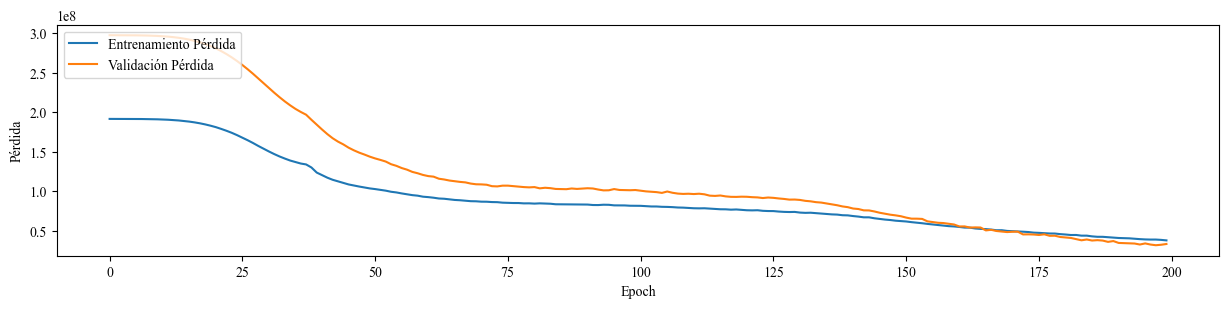

In [78]:
CTNET.summary()
history = compile_and_fit(CTNET)
Loss(history.history['loss'], history.history['val_loss'])
#Loss(history.history['loss'], history.history['val_loss'])

CTNET.save('out/CTNET.h5')

In [79]:
#Evaluar en cada segmento de 1 día dentro del 20% de los datos
num_pruebas = len(X_test) //12
num_pruebas

762

In [80]:
horizon = 12

In [100]:
y_test.shape

(9145,)

In [102]:
X_test.shape

(9145, 4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
y_pred shape: (12,)
y_test_seg shape: (12,)
X_test_seg shape: (12, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
y_pred shape: (12,)
y_test_seg shape: (12,)
X_test_seg shape: (12, 4)


C:\Users\Claudia\AppData\Local\Temp\ipykernel_18244\2673309457.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultados = pd.concat([resultados, df_temp], ignore_index=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
y_pred shape: (12,)
y_test_seg shape: (12,)
X_test_seg shape: (12, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
y_pred shape: (12,)
y_test_seg shape: (12,)
X_test_seg shape: (12, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
y_pred shape: (12,)
y_test_seg shape: (12,)
X_test_seg shape: (12, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
y_pred shape: (12,)
y_test_seg shape: (12,)
X_test_seg shape: (12, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
y_pred shape: (12,)
y_test_seg shape: (12,)
X_test_seg shape: (12, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
y_pred shape: (12,)
y_test_seg shape: (12,)
X_test_seg shape: (12, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
y_pred shape: (12,)
y_test_seg shape: (12,)
X_test_seg shape: (12, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
y_pred shape: (12,)
y_test_seg shape: (12,)
X_test_seg shape: (12, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
y_pred shape: (12,)
y_test_seg shape: (12,)
X_test_seg shape: (12, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

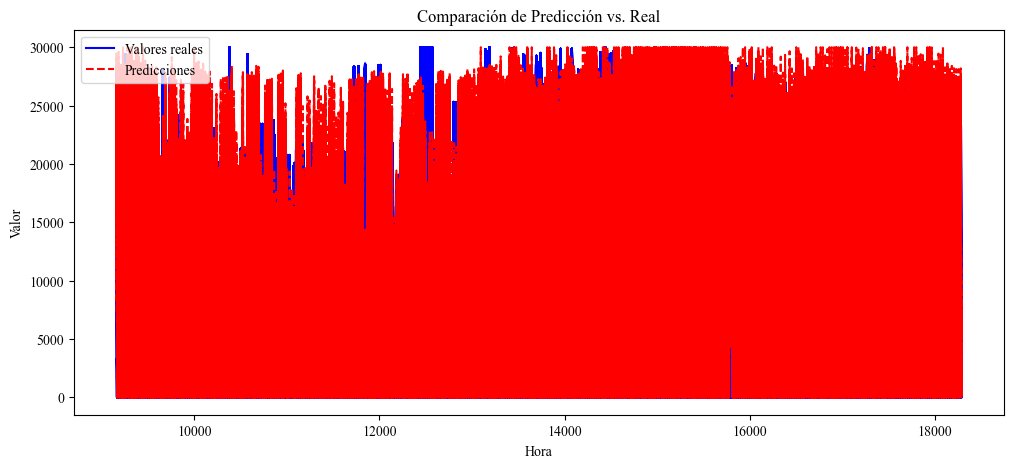

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Inicializar DataFrame para almacenar resultados
resultados = pd.DataFrame(columns=['Hora', 'Real', 'Predicho'])

# Definir la ventana de entrada y horizonte de predicción
n_input = 12   # Ventana de entrada (horas pasadas usadas como input)
horizon = 12   # Número de pasos que queremos predecir

# Ciclo de predicción
for i in range(len(X_test) - n_input - horizon + 1):  # 🔹 Moverse de 1 en 1
    inicio = i
    fin = inicio + n_input  # 🔹 Tomamos exactamente 12 pasos como entrada

    # 🔹 Seleccionar la ventana de entrada
    X_test_seg = X_test.iloc[inicio:fin, :]

    # 🔹 Obtener los valores reales correspondientes a las siguientes 12 horas
    if fin + horizon <= len(y_test):
        y_test_seg = y_test.iloc[fin:fin + horizon]
    else:
        continue  # 🔹 Evitar errores si no hay suficientes valores

    # 🔹 Verificar que `X_test_seg` tenga la forma correcta antes de predecir
    if X_test_seg.shape[0] != n_input:
        print(f"❌ Error: Se esperaban {n_input} pasos, pero se obtuvieron {X_test_seg.shape[0]}")
        continue  # 🔹 Saltar esta iteración si la ventana no tiene el tamaño correcto

    # 🔹 Ajustar la forma para que coincida con el modelo (1, 12, 4)
    X_test_seg_reshaped = X_test_seg.values.reshape(1, n_input, X_test.shape[1])

    # 🔹 Hacer la predicción de las próximas 12 horas
    y_pred = CTNET.predict(X_test_seg_reshaped)  # 🔹 Esto devuelve un array (1, 12)

    # 🔹 Convertir `y_pred` a un array 1D correctamente
    y_pred = y_pred.flatten()

    # 🔹 Limitar valores predichos a un rango aceptable
    y_pred = np.clip(y_pred, 0, 30000)

    print(f"y_pred shape: {y_pred.shape}")  # 🔹 Debe ser (12,)
    print(f"y_test_seg shape: {y_test_seg.shape}")  # 🔹 Debe ser (12,)
    print(f"X_test_seg shape: {X_test_seg.shape}")  # 🔹 Debe ser (12, 4)

    # 🔹 Obtener las horas correspondientes a la predicción
    horas_pred = X_test.index[fin:fin + horizon]

    # 🔹 Asegurar que todas las listas tienen la misma longitud
    num_datos = min(len(horas_pred), len(y_test_seg), len(y_pred))

    horas_pred = horas_pred[:num_datos]
    y_pred = y_pred[:num_datos]
    y_test_seg = y_test_seg[:num_datos]

    # 🔹 Crear DataFrame temporal con los 12 resultados
    df_temp = pd.DataFrame({
        'Hora': horas_pred,  
        'Real': y_test_seg,  
        'Predicho': y_pred  
    })

    # 🔹 Concatenar resultados
    resultados = pd.concat([resultados, df_temp], ignore_index=True)

# 🔹 Verificar los primeros resultados
print(resultados.head())

# 🔹 Graficar la comparación entre valores reales y predichos
plt.figure(figsize=(12,5))
plt.plot(resultados['Hora'], resultados['Real'], label="Valores reales", color='blue')
plt.plot(resultados['Hora'], resultados['Predicho'], label="Predicciones", linestyle="dashed", color='red')
plt.xlabel("Hora")
plt.ylabel("Valor")
plt.title("Comparación de Predicción vs. Real")
plt.legend()
plt.show()


In [105]:
resultados

,Hora,Real,Predicho
0,9156,27914.0,23758.617188
1,9157,27538.0,25559.173828
2,9158,28345.0,29461.273438
3,9159,27126.0,25228.556641
4,9160,26811.0,23205.919922
...,...,...,...
109459,18284,0.0,6994.315918
109460,18285,0.0,5011.520996
109461,18286,0.0,667.356873
109462,18287,0.0,0.000000


In [88]:
from sklearn.metrics import mean_absolute_percentage_error as mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error as mean_absolute_error
from sklearn.metrics import mean_squared_error as mean_squared_error
from sklearn.metrics import r2_score as r2_score

In [89]:
print(f"MAE: {mean_absolute_error(resultados['Real'], resultados['Predicho']):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(resultados['Real'], resultados['Predicho'])):.4f}")
print(f"R²: {r2_score(resultados['Real'], resultados['Predicho']):.4f}")

MAE: 3778.2927
RMSE: 5945.6385
R²: 0.6940


In [95]:
y_test

9145     0.0
9146     0.0
9147     0.0
9148     0.0
9149     0.0
        ... 
18285    0.0
18286    0.0
18287    0.0
18288    0.0
18289    0.0
Name: Generación, Length: 9145, dtype: float64

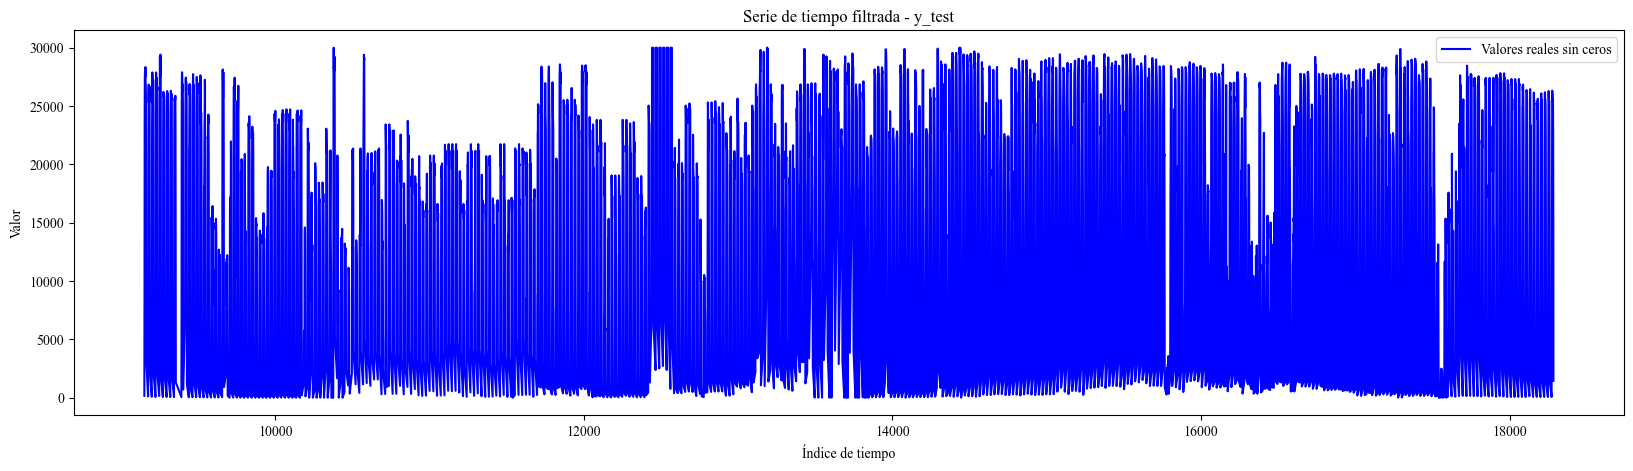

In [99]:
y_test_filtrado = y_test[y_test > 0]

plt.figure(figsize=(20,5))
plt.plot(y_test_filtrado, label="Valores reales sin ceros", color='blue')
plt.xlabel("Índice de tiempo")
plt.ylabel("Valor")
plt.title("Serie de tiempo filtrada - y_test")
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(resultados['Hora'], resultados['Real'], label='Valor Real', color='blue')
plt.plot(resultados['Hora'], resultados['Predicho'], label='Predicción', color='red', linestyle='dashed')
plt.xlabel("Hora")
plt.ylabel("Valor")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

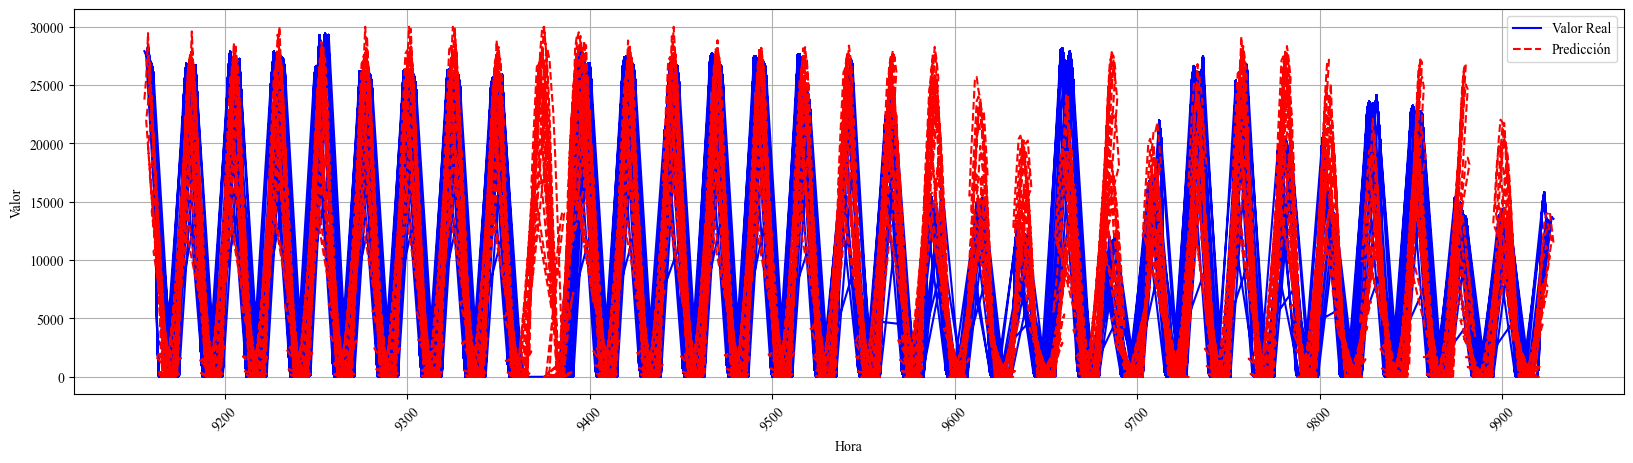

In [90]:
plt.figure(figsize=(20, 5))
plt.plot(resultados['Hora'], resultados['Real'], label='Valor Real', color='blue')
plt.plot(resultados['Hora'], resultados['Predicho'], label='Predicción', color='red', linestyle='dashed')
plt.xlabel("Hora")
plt.ylabel("Valor")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

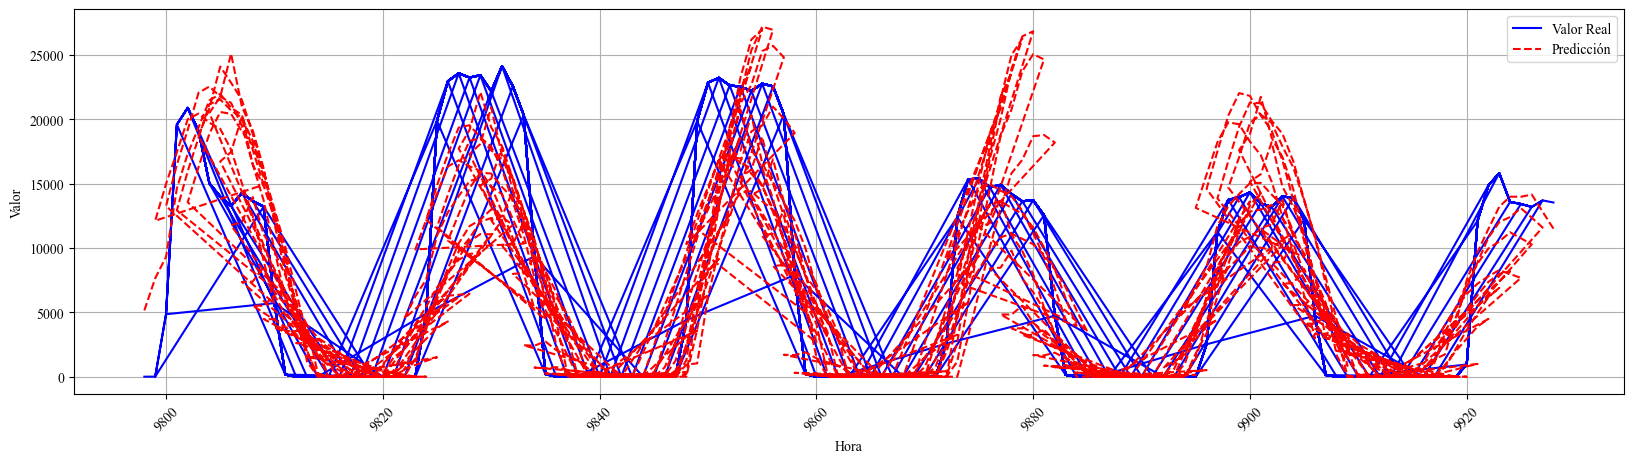

In [91]:
resultados_filtro = resultados.iloc[-(24*60):,:]
plt.figure(figsize=(20, 5))
plt.plot(resultados_filtro['Hora'], resultados_filtro['Real'], label='Valor Real', color='blue')
plt.plot(resultados_filtro['Hora'], resultados_filtro['Predicho'], label='Predicción', color='red', linestyle='dashed')
plt.xlabel("Hora")
plt.ylabel("Valor")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

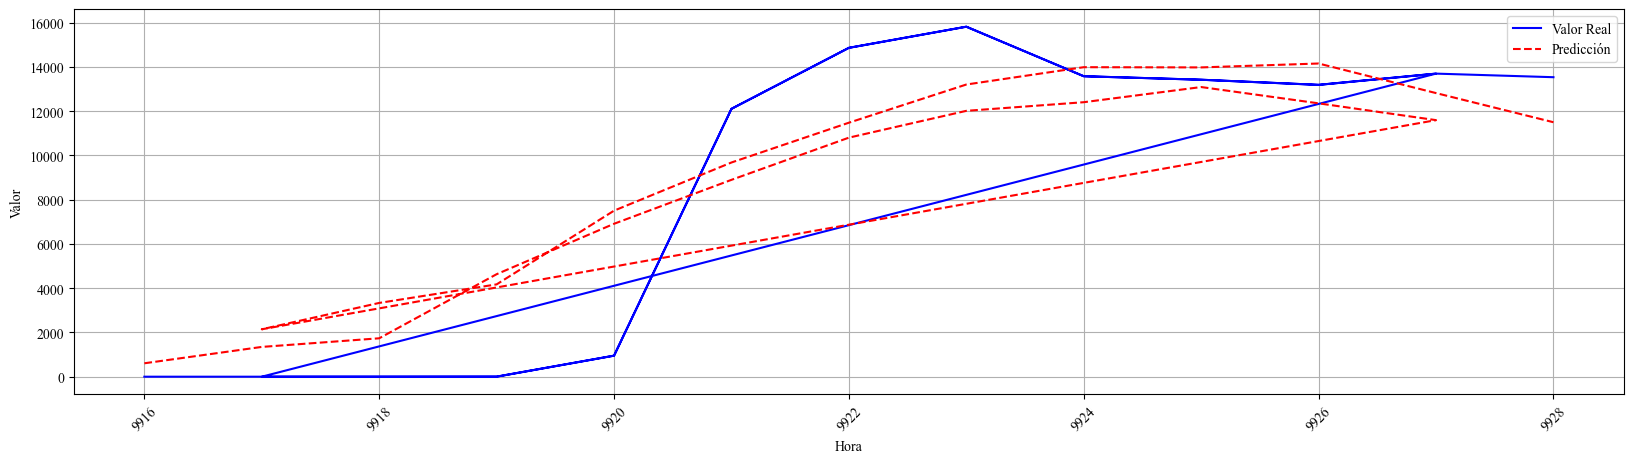

In [92]:
resultados_filtro = resultados.iloc[-(24*1):,:]
plt.figure(figsize=(20, 5))
plt.plot(resultados_filtro['Hora'], resultados_filtro['Real'], label='Valor Real', color='blue')
plt.plot(resultados_filtro['Hora'], resultados_filtro['Predicho'], label='Predicción', color='red', linestyle='dashed')
plt.xlabel("Hora")
plt.ylabel("Valor")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()